# mass binning

In [1]:
from   astropy.io import fits
import numpy as np
from   astropy.table import Table
import matplotlib.pyplot as plt
from   scripts.tools    import *
from   scripts.hst3d      import *
from   scripts.jwst       import *
obj_lis = Table.read('obj_lis_selected.fits')

bins_m = [-np.inf,9.75,10.5,np.inf]
binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)
bins_z  = [-np.inf,1.11,np.inf]
binning_z = np.digitize(obj_lis['z_MAP'],bins_z)
bin_label_m = ['8<logm<9.75','9.75<logm<10.5','10.5<logm<11.25']
bin_label_z = ['0.7<z<1.1','1.1<z<1.5']

obj_lis['bin_m'] = binning_m
obj_lis['bin_z'] = binning_z
obj_lis.write('obj_lis_selected_bins.fits',overwrite=True)
select = np.logical_and(np.logical_and(obj_lis['tag']!='agn',obj_lis['manual_select']=='keep'),obj_lis['mass']>0)

def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

print(len(obj_lis))
print(len(obj_lis[select]))
obj_lis_sel = obj_lis[select]

C:\Users\26715\AppData\Local\Temp\ipykernel_14756\318552854.py:11: RuntimeWarning: invalid value encountered in log10
  binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)


158
87


C:\Users\26715\AppData\Local\Temp\ipykernel_7584\3588489403.py:3: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(obj_lis['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)


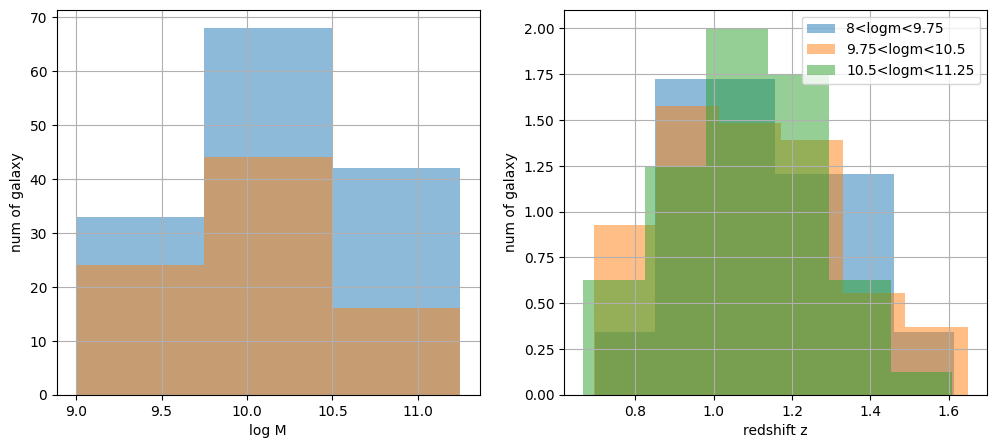

In [ ]:
ax = plt.figure(figsize=(12,5))
ax.add_subplot(121)
plt.hist(np.log10(obj_lis['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)
plt.hist(np.log10(obj_lis_sel['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)
plt.xlabel('log M');plt.ylabel('num of galaxy')
plt.grid()

ax.add_subplot(122)
plt.hist(obj_lis[binning_m==1]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label_m[0])
plt.hist(obj_lis[binning_m==2]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label_m[1])
plt.hist(obj_lis[binning_m==3]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label_m[2])
plt.xlabel('redshift z');plt.ylabel('num of galaxy')
plt.legend();plt.grid()
plt.show()


# radial profiles, in [kpc] radius

method 1 ha hb balmer data all from surface brightness measurement then taking the median

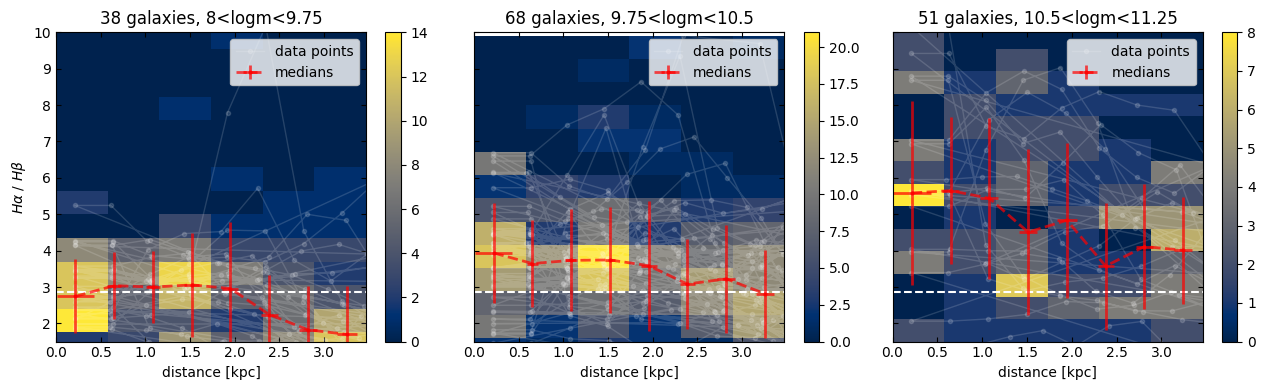

[array([0.        , 0.43404225, 0.86808449, 1.30212674, 1.73616898,
       2.17021123, 2.60425347, 3.03829572]), array([0.        , 0.43439537, 0.86879075, 1.30318612, 1.73758149,
       2.17197686, 2.60637224, 3.04076761]), array([0.        , 0.43235913, 0.86471826, 1.29707739, 1.72943652,
       2.16179565, 2.59415478, 3.0265139 ])]


In [9]:
fig = plt.figure(figsize=(13, 4))  # Create a figure with size 13x4 inches

def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

binned_radius = []
median_balmer = []
median_balmer_err = []

for i in range(len(bins_m) - 1):
    ax = fig.add_subplot(1, 3, i + 1)  # Add a subplot in a 1x3 grid
    ax.tick_params(direction='in',which='both', top=True, right=True)
    if i !=0: ax.set_yticklabels([])

    r_lis = np.array([])  # Initialize r_lis as an empty array
    balmer_lis = np.array([])  # Initialize balmer_lis as an empty array

    for obj in obj_lis_sel[obj_lis_sel['bin_m'] == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
        with fits.open(path) as hdu:
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV', hdu)[1].data).transpose()
            # Read and transpose data from the FITS file

            r_lis = np.append(r_lis, r)  # Append r to r_lis
            balmer_lis = np.append(balmer_lis, balmer_r)  # Append balmer_r to balmer_lis

    r_bins_center = bin_center(r_lis)  # Calculate the center of r_lis

    mask = np.logical_and(r_lis < 3.5, balmer_lis < 12)  # Create a mask to filter r_lis < 3 and balmer_lis < 12
    plt.hist2d(r_lis[mask], balmer_lis[mask], bins=(6, 15), cmap='cividis')  # Plot a 2D histogram
    plt.plot(r_bins_center[mask],balmer_lis[mask], linewidth=1, marker='.', color='white', alpha=0.15,label='data points')  # Plot a scatter plot
    plt.title(f'{len(obj_lis[binning_m == i + 1])} galaxies, {bin_label_m[i]}')  # Set the subplot title
    plt.xlim(0,)  # Set the x-axis limit
    plt.ylim(1.5,10)
    plt.xlabel('distance [kpc]')  # Set the x-axis label
    plt.axhline(2.86, 0, 7, linestyle='--', color='white')  # Draw a horizontal line
    plt.colorbar()  # Add a color bar
    if i == 0:
        plt.ylabel(r'$H\alpha$ / $H\beta$')
    # Radius binning and taking medians
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=9)  # Calculate bin edges
    bin_indices = np.digitize(r_lis[mask], bin_edges)  # Assign r_lis values to bins
    median_values = [np.median(balmer_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]  # Calculate median values for each bin
    std_values = [np.std(balmer_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]  # Calculate standard deviation for each bin
    std_r_values = [np.std(r_lis[mask][bin_indices==j])for j in range(1,len(bin_edges))]
    # Plot medians
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    plt.errorbar(bin_centers, median_values, yerr=std_values, xerr=std_r_values, fmt='--',color="r",alpha=0.7, linewidth=2,marker='.',markersize=4,label='medians',elinewidth=2)  # Plot medians with error bars
    
    #save_results
    binned_radius.append(bin_edges[:-1])
    median_balmer.append(median_values)
    median_balmer_err.append(std_values)
    plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('radial_balmer_decrem/test_radial_profile_median')
plt.show()  # Display the figure
print(binned_radius)

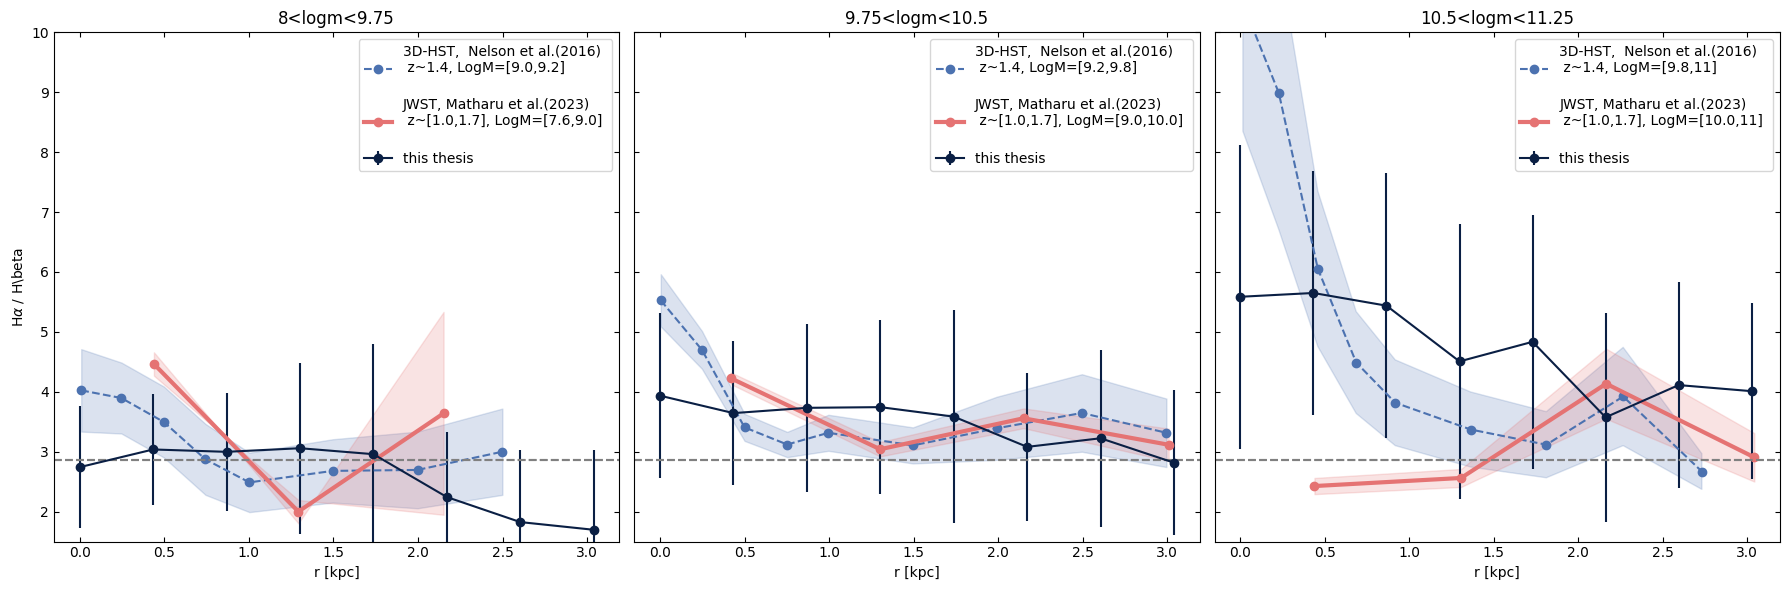

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
hst3d_label = ['LogM=[9.0,9.2]','LogM=[9.2,9.8]','LogM=[9.8,11]']
jwst_label = ['LogM=[7.6,9.0]','LogM=[9.0,10.0]','LogM=[10.0,11]']
for i, ax in enumerate(axes):
    ax.tick_params(direction='in',which='both', top=True, right=True)

    r = binned_radius[i]
    median = median_balmer[i]
    std = median_balmer_err[i]
    
    # Use loop index i to select color, avoiding out of range
    color = ['r', 'g', 'b'][i % 3]  # Use modulo operation to ensure index is within range
    mass  = ['low','middle','high'][i%3]
    r_theo1, balmer_theo1, balmer_err_theo1 = hst3d_result(mass)
    r_theo2, balmer_theo2, balmer_err_theo2 = jwst_result(mass)

    ax.errorbar(r, median, yerr=std, marker='o', fmt='-', color="#0A1F44", label='this thesis')  # Add label for distinction
    
    ax.plot(r_theo1,balmer_theo1,marker='o',linestyle='--',color="#4C72B0",label=f'3D-HST,  Nelson et al.(2016) \n z~1.4, {hst3d_label[i]} \n')
    ax.axhline(2.86, linestyle='--', color='grey')  # Draw a horizontal line
    ax.fill_between(r_theo1,balmer_theo1-balmer_err_theo1,balmer_theo1+balmer_err_theo1,color="#4C72B0",alpha=0.2)
    
    ax.plot(r_theo2,balmer_theo2,marker='o',linestyle='-',color="#E57373",label=f'JWST, Matharu et al.(2023) \n z~[1.0,1.7], {jwst_label[i]} \n',linewidth=3)
    ax.axhline(2.86, linestyle='--', color='grey')  # Draw a horizontal line
    ax.fill_between(r_theo2,balmer_theo2-balmer_err_theo2,balmer_theo2+balmer_err_theo2,color="#E57373",alpha=0.2)
    
    
    # Add legend
    ax.legend()
    # Add title and axis labels
    ax.set_title(bin_label_m[i])
    ax.set_xlabel('r [kpc]')
    if i ==0:
        ax.set_ylabel(r'H$\alpha$ / H\beta')
    if i !=0:
        ax.set_yticklabels([])
    ax.set_ylim(1.5,10)
# Display the plot
plt.tight_layout()
plt.savefig('radial_balmer_decrem/test2_comparison')
plt.show()

# attenuation, in kpc

In [1]:
fig = plt.figure(figsize=(13, 4))  # Create a figure with size 13x4 inches

for i in range(len(bins_m) - 1):
    ax = fig.add_subplot(1, 3, i + 1)  # Add a subplot in a 1x3 grid
    r_lis = np.array([])  # Initialize r_lis as an empty array
    A_lis = np.array([])  # Initialize balmer_lis as an empty array

    for obj in obj_lis_sel[obj_lis_sel['bin_m'] == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
        with fits.open(path) as hdu:
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV', hdu)[1].data).transpose()
            # Read and transpose data from the FITS file

            r_lis = np.append(r_lis, r)  # Append r to r_lis
            A_lis = np.append(A_lis, A_a)  # Append balmer_r to balmer_lis

    r_bins_center = bin_center(r_lis)  # Calculate the center of r_lis

    mask = np.logical_and(r_lis < 3, np.isfinite(A_lis))  # Create a mask to filter r_lis < 3 and balmer_lis < 12
    plt.hist2d(r_lis[mask], A_lis[mask], bins=(6, 15), cmap='cividis')  # Plot a 2D histogram
    plt.plot(r_bins_center[mask], A_lis[mask], linewidth=1, marker='.', color='white', alpha=0.15)  # Plot a scatter plot
    plt.title(f'{len(obj_lis[binning_m == i + 1])} obj with {bin_label_m[i]}')  # Set the subplot title
    plt.xlim(0,)  # Set the x-axis limit
    plt.xlabel('distance [kpc]')  # Set the x-axis label
    plt.axhline(0, 0, 7, linestyle='--', color='white')  # Draw a horizontal line
    plt.colorbar()  # Add a color bar

    # Radius binning and taking medians
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=4)  # Calculate bin edges
    bin_indices = np.digitize(r_lis[mask], bin_edges)  # Assign r_lis values to bins
    median_values = [np.median(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]  # Calculate median values for each bin
    std_values = [np.std(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]  # Calculate standard deviation for each bin

    # Plot medians
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    plt.errorbar(bin_centers, median_values, yerr=std_values, fmt='r-', linewidth=2,alpha=0.5)  # Plot medians with error bars

plt.show()  # Display the figure

NameError: name 'plt' is not defined

# radial profiles, in [kpc] radius

method 2  ha hb balmer data from surface brightness measurement, using the median and std from the 2 surface brightness to calculate balmer decrement

# ha/hb, in kpc

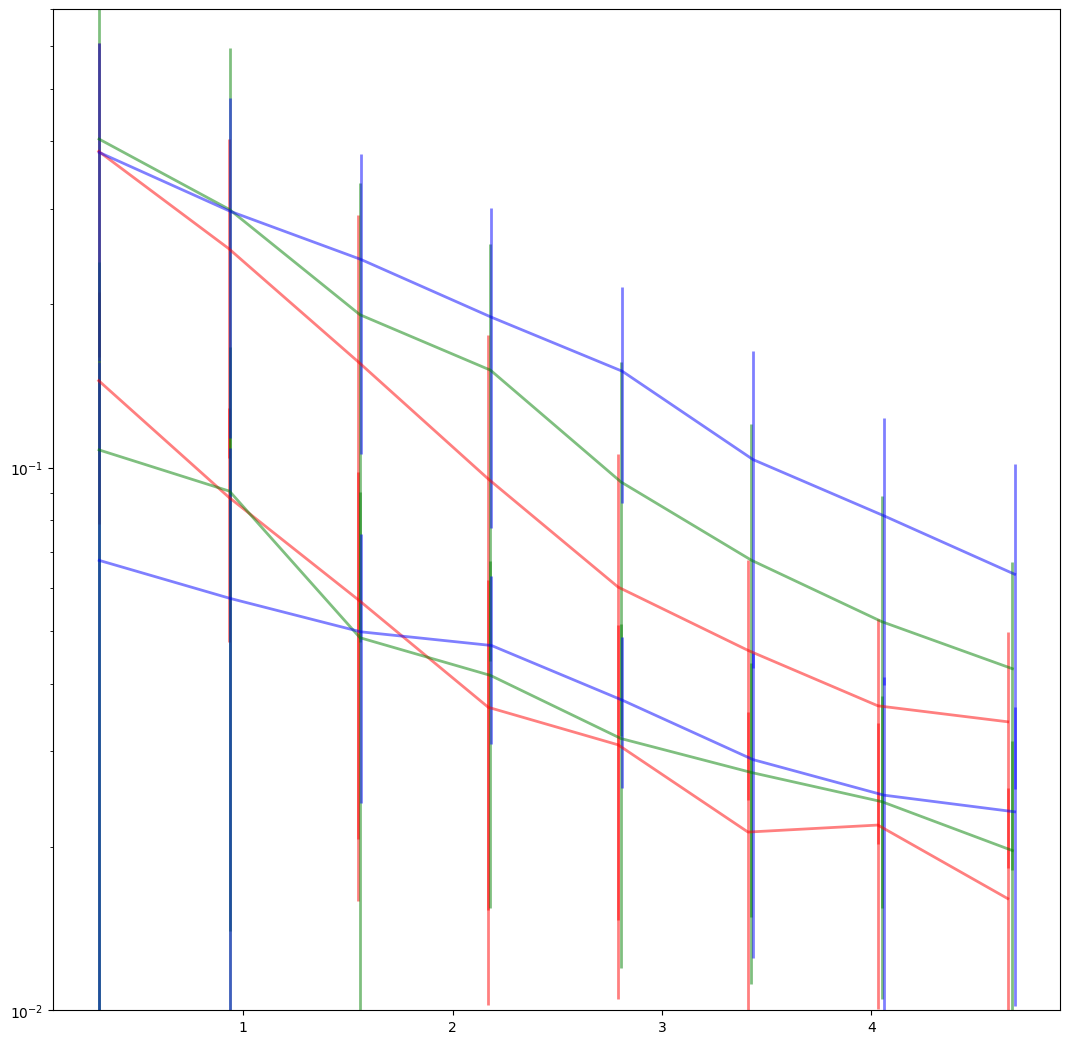

In [11]:
fig = plt.figure(figsize=(13, 13))  # Create a figure with size 13x4 inches

for i in range(len(bins_m) - 1):
    #ax = fig.add_subplot(1, 3, i + 1)  # Add a subplot in a 1x3 grid
    r_lis = np.array([])  # Initialize r_lis as an empty array
    ha_lis = np.array([])  # Initialize balmer_lis as an empty array
    hb_lis = np.array([])
    for obj in obj_lis_sel[obj_lis_sel['bin_m'] == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
        with fits.open(path) as hdu:
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV', hdu)[1].data).transpose()
            # Read and transpose data from the FITS file

            r_lis = np.append(r_lis, r)  # Append r to r_lis
            ha_lis = np.append(ha_lis, ha_r)  # Append halpha brightness
            hb_lis = np.append(hb_lis, hb_r)  # Append halpha brightness


    r_bins_center = bin_center(r_lis)  # Calculate the center of r_lis

    mask = np.logical_and(np.logical_and(r_lis < 5, np.isfinite(ha_lis)),np.isfinite(hb_lis))  # Create a mask to filter r_lis < 3 and balmer_lis < 12

    '''
    plt.hist2d(r_lis[mask], A_lis[mask], bins=(6, 15), cmap='cividis')  # Plot a 2D histogram
    plt.plot(r_bins_center[mask], A_lis[mask], linewidth=1, marker='.', color='white', alpha=0.15)  # Plot a scatter plot
    plt.title(f'{len(obj_lis[binning_m == i + 1])} obj with {bin_label_m[i]}')  # Set the subplot title
    plt.xlim(0,)  # Set the x-axis limit
    plt.xlabel('distance [kpc]')  # Set the x-axis label
    plt.axhline(0, 0, 7, linestyle='--', color='white')  # Draw a horizontal line
    plt.colorbar()  # Add a color bar
    '''
    # Radius binning and taking medians
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=9)  # Calculate bin edges
    bin_indices = np.digitize(r_lis[mask], bin_edges)  # Assign r_lis values to bins

    ha_median_values = np.array([np.median(ha_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))])  # Calculate median values for each bin
    ha_std_values = np.array([np.std(ha_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))])  # Calculate standard deviation for each bin

    hb_median_values = np.array([np.median(hb_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))])  # Calculate median values for each bin
    hb_std_values = np.array([np.std(hb_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))])  # Calculate standard deviation for each bin

    median_values = ha_median_values / hb_median_values
    std_values = ((ha_std_values/hb_median_values)**2 + (hb_std_values**2 * (ha_median_values/hb_median_values**2)**2))**0.5

    # Plot medians
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    #plt.errorbar(bin_centers, median_values, yerr=std_values, fmt='r-', linewidth=2,alpha=0.5)  # Plot medians with error bars
    plt.errorbar(bin_centers, ha_median_values, yerr=ha_std_values, fmt='-',color=['r','g','b'][i], linewidth=2,alpha=0.5)  # Plot medians with error bars
    plt.errorbar(bin_centers, hb_median_values, yerr=hb_std_values, fmt='-',color=['r','g','b'][i], linewidth=2,alpha=0.5)  # Plot medians with error bars
    plt.ylim(0.01,0.7)
    plt.yscale('log')
plt.show()  # Display the figure

# radial profiles, in r_eff

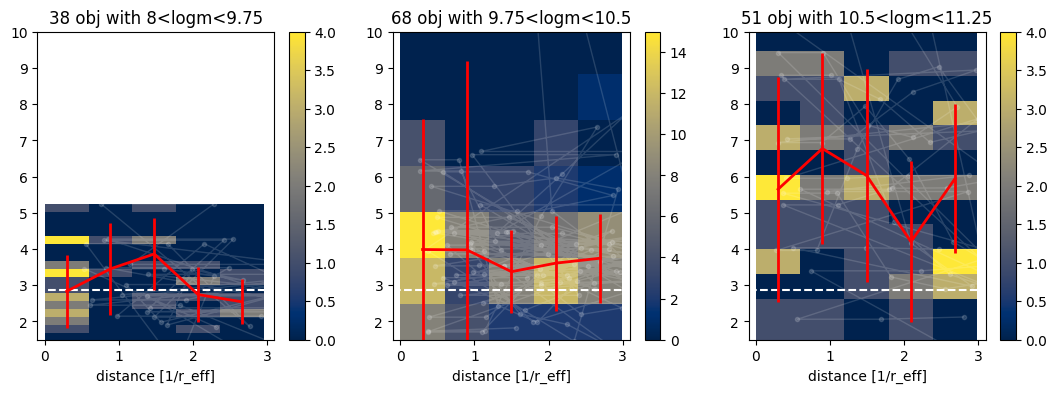

In [15]:
fig = plt.figure(figsize=(13, 4))

for i in range(len(bins_m) - 1):
    ax = fig.add_subplot(1, 3, i + 1)
    r_lis = np.array([])
    r_bins_center = np.array([])
    A_lis = np.array([])
    r_pix_lis = np.array([])
    balmer_pix_lis = np.array([])

    for obj in obj_lis_sel[obj_lis_sel['bin_m'] == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        with fits.open(path) as hdu:
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV', hdu)[1].data).transpose()
            # Convert actual radius to effective radius
            r = r / obj['re']
            r_bins_center = np.append(r_bins_center,bin_center(r))
            r_lis = np.append(r_lis, r)
            A_lis = np.append(A_lis, balmer_r)

            distances_obj, balmer_pix, balmer_pix_err = np.vstack(find_data('PIX_RAD_PROFILE', hdu)[1].data).transpose()
            r_pix_lis = np.append(r_pix_lis, distances_obj)
            balmer_pix_lis = np.append(balmer_pix_lis, balmer_pix)

    
    # Mask
    mask = np.logical_and(r_lis < 3, np.isfinite(A_lis))
    plt.hist2d(r_lis[mask], A_lis[mask], bins=(5, 20), cmap='cividis')
    plt.plot(r_bins_center[mask], A_lis[mask], linewidth=1, marker='.', color='white', alpha=0.15)
    plt.xlim(-0.1,3.1);plt.ylim(0)
    plt.title(f'{len(obj_lis[binning_m == i + 1])} obj with {bin_label_m[i]}')
    plt.xlabel('distance [1/r_eff]')
    plt.axhline(2.86, 0, 7, linestyle='--', color='white')
    plt.colorbar()

    # Bin the radius and calculate the median of each binned radius
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=6)
    bin_indices = np.digitize(r_lis[mask], bin_edges)
    median_values = [np.median(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]
    std_values    = [np.std(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]

    # Plot the median line
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.errorbar(bin_centers, median_values,yerr= std_values,fmt='r-', linewidth=2)
    plt.ylim(1.5,10)
plt.show()

# radial profiles, in [reff] radius

method 2  ha hb balmer data from surface brightness measurement, using the median and std from the 2 surface brightness to calculate balmer decrement

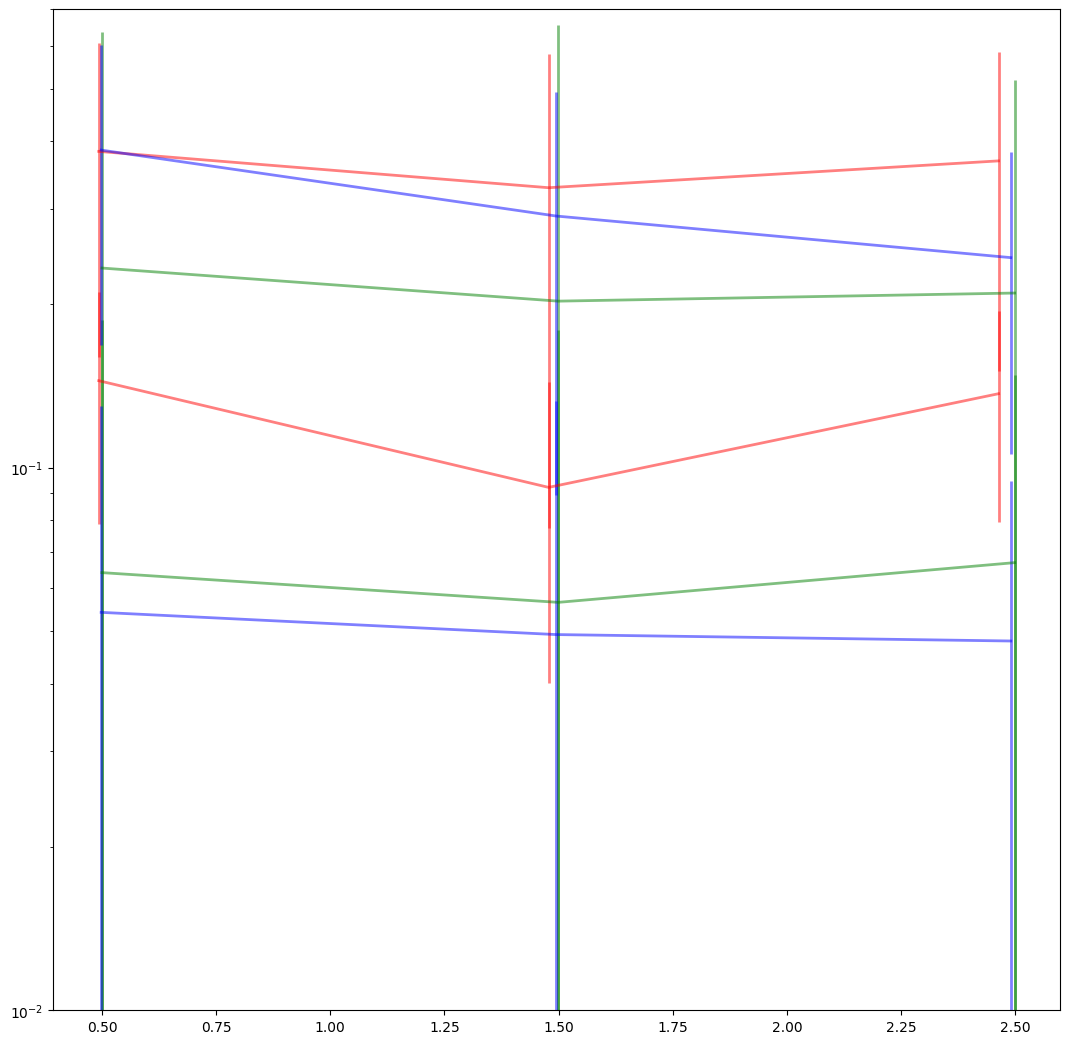

In [19]:
fig = plt.figure(figsize=(13, 13))  # Create a figure with size 13x4 inches

for i in range(len(bins_m) - 1):
    #ax = fig.add_subplot(1, 3, i + 1)  # Add a subplot in a 1x3 grid
    r_lis = np.array([])  # Initialize r_lis as an empty array
    ha_lis = np.array([])  # Initialize balmer_lis as an empty array
    hb_lis = np.array([])
    for obj in obj_lis_sel[obj_lis_sel['bin_m'] == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
        with fits.open(path) as hdu:
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV', hdu)[1].data).transpose()
            # Read and transpose data from the FITS file
            r = r/obj['re']
            r_lis = np.append(r_lis, r)  # Append r to r_lis
            ha_lis = np.append(ha_lis, ha_r)  # Append halpha brightness
            hb_lis = np.append(hb_lis, hb_r)  # Append halpha brightness


    r_bins_center = bin_center(r_lis)  # Calculate the center of r_lis

    mask = np.logical_and(np.logical_and(r_lis < 3, np.isfinite(ha_lis)),np.isfinite(hb_lis))  # Create a mask to filter r_lis < 3 and balmer_lis < 12

    '''
    plt.hist2d(r_lis[mask], A_lis[mask], bins=(6, 15), cmap='cividis')  # Plot a 2D histogram
    plt.plot(r_bins_center[mask], A_lis[mask], linewidth=1, marker='.', color='white', alpha=0.15)  # Plot a scatter plot
    plt.title(f'{len(obj_lis[binning_m == i + 1])} obj with {bin_label_m[i]}')  # Set the subplot title
    plt.xlim(0,)  # Set the x-axis limit
    plt.xlabel('distance [kpc]')  # Set the x-axis label
    plt.axhline(0, 0, 7, linestyle='--', color='white')  # Draw a horizontal line
    plt.colorbar()  # Add a color bar
    '''
    # Radius binning and taking medians
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=4)  # Calculate bin edges
    bin_indices = np.digitize(r_lis[mask], bin_edges)  # Assign r_lis values to bins

    ha_median_values = np.array([np.median(ha_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))])  # Calculate median values for each bin
    ha_std_values = np.array([np.std(ha_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))])  # Calculate standard deviation for each bin

    hb_median_values = np.array([np.median(hb_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))])  # Calculate median values for each bin
    hb_std_values = np.array([np.std(hb_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))])  # Calculate standard deviation for each bin

    median_values = ha_median_values / hb_median_values
    std_values = ((ha_std_values/hb_median_values)**2 + (hb_std_values**2 * (ha_median_values/hb_median_values**2)**2))**0.5

    # Plot medians
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    #plt.errorbar(bin_centers, median_values, yerr=std_values, fmt='r-', linewidth=2,alpha=0.5)  # Plot medians with error bars
    plt.errorbar(bin_centers, ha_median_values, yerr=ha_std_values, fmt='-',color=['r','g','b'][i], linewidth=2,alpha=0.5)  # Plot medians with error bars
    plt.errorbar(bin_centers, hb_median_values, yerr=hb_std_values, fmt='-',color=['r','g','b'][i], linewidth=2,alpha=0.5)  # Plot medians with error bars
    plt.ylim(0.01,0.7)
    plt.yscale('log')
plt.show()  # Display the figure

# attenuation in r_eff

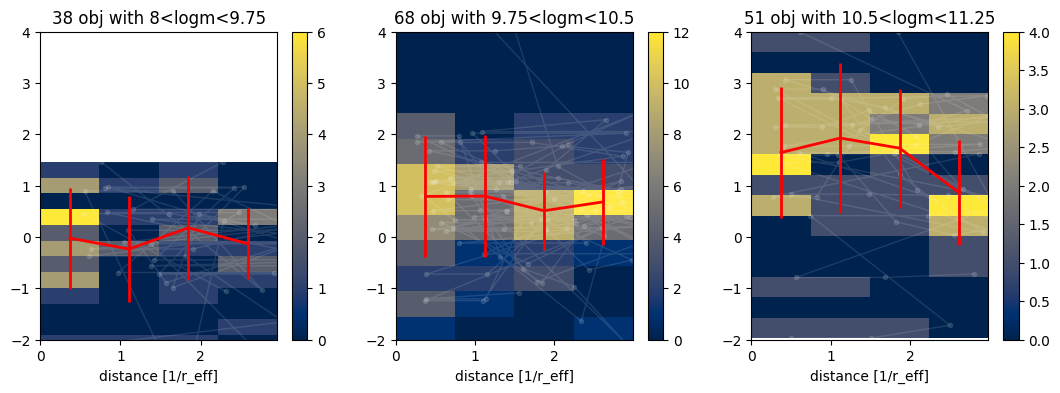

In [13]:
ax =plt.figure(figsize=(13,4))

for i in range(len(bins_m)-1):
    ax.add_subplot(int(f'13{i+1}'))
    r_lis = np.array(());     r_bins_center = np.array([])
    A_lis = np.array(())
    r_pix_lis = np.array(()); balmer_pix_lis = np.array(())


    for obj in obj_lis_sel[obj_lis_sel['bin_m']==i+1]:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
            r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV',hdu)[1].data).transpose()
            #now convert actual radius to effective radius
            r = r / obj['re']
            r_bins_center = np.append(r_bins_center,bin_center(r))
            r_lis = np.append(r_lis,r)
            A_lis = np.append(A_lis,A_a)

            distances_obj, balmer_pix, balmer_pix_err = np.vstack(find_data('PIX_RAD_PROFILE',hdu)[1].data).transpose()
            r_pix_lis = np.append(r_pix_lis,distances_obj)
            balmer_pix_lis = np.append(balmer_pix_lis,balmer_pix)

    mask = np.logical_and(r_lis<3,np.isfinite(A_lis))
    plt.hist2d(r_lis[mask],A_lis[mask],bins=(4,15),cmap = 'cividis')#, bins=(10,20))
    plt.plot(r_bins_center[mask],A_lis[mask],linewidth=1,marker='.',color='white',alpha=0.12)
    plt.ylim(-2,4)
    plt.title(f'{len(obj_lis[binning_m==i+1])} obj with {bin_label_m[i]}')
    plt.xlabel('distance [1/r_eff]')
    plt.colorbar()


    # Bin the radius and calculate the median of each binned radius
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=5)
    bin_indices = np.digitize(r_lis[mask], bin_edges)
    median_values = [np.median(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]
    std_values    = [np.std(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]

    # Plot the median line
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.errorbar(bin_centers, median_values,yerr= std_values,fmt='r-', linewidth=2)

plt.show()

ValueError: not enough values to unpack (expected 7, got 3)

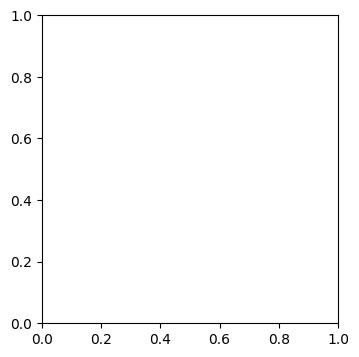

In [14]:
ax =plt.figure(figsize=(13,4))

for i in range(len(bins_m)-1):
    ax.add_subplot(int(f'13{i+1}'))
    r_lis = np.array(()); A_lis = np.array(())
    r_pix_lis = np.array(()); balmer_pix_lis = np.array(())

    for obj in obj_lis_sel[obj_lis_sel['bin_m']==i+1]:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
            r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err = np.vstack(find_data('PIX_RAD_PROFILE',hdu)[1].data).transpose()
            r_lis = np.append(r_lis,r)
            A_lis = np.append(A_lis,balmer_r)

            distances_obj, balmer_pix, balmer_pix_err = np.vstack(find_data('PIX_RAD_PROFILE',hdu)[1].data).transpose()
            r_pix_lis = np.append(r_pix_lis,distances_obj)
            balmer_pix_lis = np.append(balmer_pix_lis,balmer_pix)


    mask = np.logical_and(r_lis<5,A_lis<12)
    #mask = np.logical_and(r_lis<100000,balmer_lis<14000000)
    plt.hist2d(r_lr_lis,8);plt.ylim(0,14)
    plt.title(f'{len(obj_lis[binning_m==i+1])} obj with {bin_label_m[i]}')
    plt.xlabel('distance [kpc]')
    plt.axhline(2.86,0,7,linestyle='--',color='white')
    plt.colorbar()
plt.show()

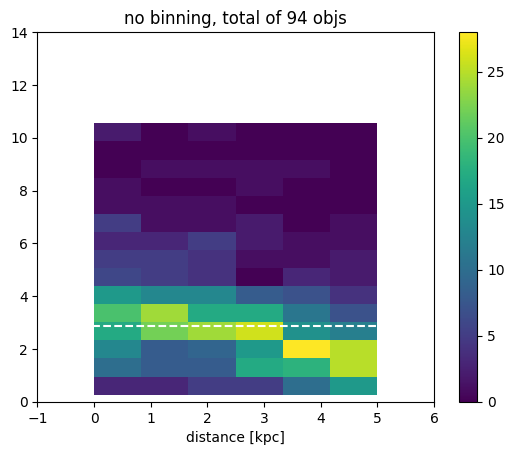

In [ ]:
r_lis = np.array(()); A_lis = np.array(())
for obj in obj_lis_sel:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
                r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err = np.vstack(find_data('RAD_PROFILE',hdu)[1].data).transpose()

                r_lis = np.append(r_lis,r)
                A_lis = np.append(A_lis,balmer_r)
                #plt.errorbar(r,balmer_r,yerr = balmer_r_err,linewidth=1,marker='.',elinewidth=0)
                
mask = np.logical_and(r_lis<5,A_lis<12)
plt.hist2d(r_lis[mask],A_lis[mask],bins=(6,15))#, bins=(10,20))
plt.xlim(-1,6);plt.ylim(0,14)
plt.title(f'no binning, total of {len(obj_lis_sel)} objs')
plt.xlabel('distance [kpc]')
plt.axhline(2.86,0,7,linestyle='--',color='white')
plt.colorbar()

ValueError: too many values to unpack (expected 7)

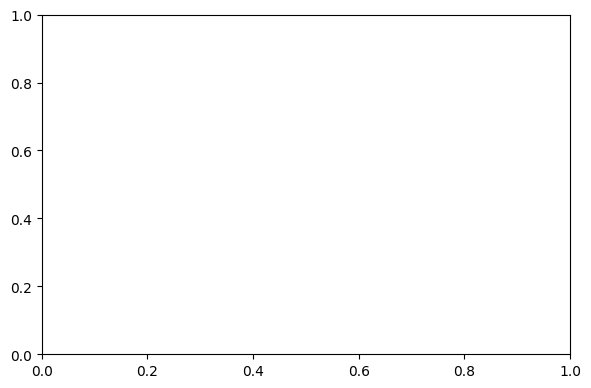

In [ ]:
index=1
ax =plt.figure(figsize=(15,15))
for i in range(len(bins_m)-1):
    for j in range(len(bins_z)-1):
        ax.add_subplot(int(f'32{index}'));index+=1
        r_lis = np.array(()); ha_lis = []; hb_lis = []; A_lis = np.array(())
        
        for obj in obj_lis[np.logical_and(binning_m==i+1,binning_z==j+1)]:
            path = f"data_extracted/{file_name(obj,prefix='extracted')}"
            with fits.open(path) as hdu:
                r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err = np.vstack(find_data('RAD_PROFILE_CONV',hdu)[1].data).transpose()
                r_lis = np.append(r_lis,r)
                A_lis = np.append(A_lis,balmer_r)
                #plt.errorbar(r,balmer_r,yerr = balmer_r_err,linewidth=1,marker='.',elinewidth=0)
                
        mask = np.logical_and(r_lis<7,A_lis<15)
        plt.hist2d(r_lis[mask],A_lis[mask],bins=(4,10),cmap = 'cividis')#, bins=(10,20))
        plt.xlim(-1,8);plt.ylim(0,14)
        plt.title(f'{bin_label_z[j]}')
        plt.ylabel(f'{len(obj_lis[np.logical_and(binning_m==i+1,binning_z==j+1)])} obj with {bin_label_m[i]}')
        plt.xlabel('distance [kpc]')
        plt.colorbar()
        plt.grid()
        plt.axhline(2.86,0,7,linestyle='--',color='white')

plt.show()